In [18]:
# imports
import random as rd
import pandas as pd
import numpy as np
from typing import List, Tuple
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import KFold
import itertools
import seaborn as sns


In [3]:
# constants and initialization
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'artist'
top_fraction = 0.2
user_events_file = 'data/user_events.csv'
low_user_file = 'data/low_main_users.csv'
medium_user_file = 'data/medium_main_users.csv'
high_user_file = 'data/high_main_users.csv'
performance_data_file = 'data/performance_data.csv'
low_mae_data_file = 'data/low_mae_data.csv'
med_mae_data_file = 'data/med_mae_data.csv'
high_mae_data_file = 'data/high_mae_data.csv'
all_mae_data_file = 'data/all_mae_data.csv'
performance_data_cv_file = 'data/performance_data_cv.csv'
low_mae_data_cv_file = 'data/low_mae_data_cv.csv'
med_mae_data_cv_file = 'data/med_mae_data_cv.csv'
high_mae_data_cv_file = 'data/high_mae_data_cv.csv'
all_mae_data_cv_file = 'data/all_mae_data_cv.csv'
two_sample_ttest_data_file = 'data/two_sample_ttest_data.csv'
two_sample_ttest_data_cv_file = 'data/two_sample_ttest_data_cv.csv'
paired_sample_ttest_data_file = 'data/paired_sample_ttest_data.csv'
paired_sample_ttest_data_cv_file = 'data/paired_sample_ttest_data_cv.csv'

In [3]:
# read user events
cols = ['user', 'artist', 'album', 'track', 'timestamp']
df_events = pd.read_csv(user_events_file, sep='\t', names=cols)
print('No. of user events: ' + str(len(df_events)))

No. of user events: 28718087


In [4]:
# create user-item matrix
df_events = df_events.groupby(['user', predict_col]).size().reset_index(name='count')
print('No. user-item interactions: ' + str(len(df_events)))

No. user-item interactions: 1755361


In [5]:
df_events.head()

,user,artist,count
0,1021445,12,43
1,1021445,16,1
2,1021445,28,7
3,1021445,29,1
4,1021445,46,1


In [6]:
df_events = df_events[df_events['count'] >= item_threshold]
print('No. filtered user events: ' + str(len(df_events)))
print('No. filtered items: ' + str(len(df_events[predict_col].unique())))

No. filtered user events: 1755361
No. filtered items: 352805


In [7]:
# get user distribution
user_dist = df_events['user'].value_counts()
num_users = len(user_dist)
print('Mean artists per user: ' + str(user_dist.mean()))
print('Min artists per user: ' + str(user_dist.min()))
print('Max artists per user: ' + str(user_dist.max()))

Mean artists per user: 585.1203333333333
Min artists per user: 18
Max artists per user: 4011


In [8]:
# get item distribution
item_dist = df_events[predict_col].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 352805


In [9]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 70561


In [10]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user_id')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user_id')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user_id')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


In [11]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
for u, df in df_events.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


In [12]:
scaled_df_events = pd.DataFrame()
for user_id, group in df_events.groupby('user'):
    min_rating = group['count'].min()
    max_rating = group['count'].max()
    scaler = MinMaxScaler(feature_range=(1, 1000))
    scaled_ratings = scaler.fit_transform(group['count'].values.reshape(-1, 1).astype(float))
    new_rows = group.copy()
    new_rows['count'] = scaled_ratings
    scaled_df_events = scaled_df_events.append(new_rows)

scaled_df_events.head()
#scaled_df_events = scaled_df_events.set_index('user') # needed for new python/surprise version

,user,artist,count
0,1021445,12,184.222707
1,1021445,16,1.000000
2,1021445,28,27.174672
3,1021445,29,1.000000
4,1021445,46,1.000000


In [13]:
df_events = scaled_df_events
print('Min rating: ' + str(df_events['count'].min()))
print('Max rating: ' + str(df_events['count'].max()))

Min rating: 1.0
Max rating: 1000.0000000000001


In [14]:
reader = Reader(rating_scale=(df_events['count'].min(), df_events['count'].max()))
df_events.head()

,user,artist,count
0,1021445,12,184.222707
1,1021445,16,1.000000
2,1021445,28,27.174672
3,1021445,29,1.000000
4,1021445,46,1.000000


In [15]:
# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_events, reader)

In [16]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [17]:
def get_top_n_random(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n

In [18]:
def get_top_n_mp(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

In [26]:
def get_mae_of_groups(predictions) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    print('All: ')
    mae_all: float = accuracy.mae(predictions)
    all_predictions = []
    low_predictions = []
    med_predictions = []
    high_predictions = []
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        current_mae = accuracy.mae(prediction, verbose=False)

        all_predictions.append(current_mae)

        if uid in low_users.index:
            low_predictions.append(current_mae)
        elif uid in medium_users.index:
            med_predictions.append(current_mae)
        else:
            high_predictions.append(current_mae)

    mae_low: float = np.mean(low_predictions)
    mae_med: float = np.mean(med_predictions)
    mae_high: float = np.mean(high_predictions)
    print('LowMS: ' + str(mae_low))
    print('MedMS: ' + str(mae_med))
    print('HighMS: ' + str(mae_high))

    return (pd.DataFrame({'mae_all': [mae_all], 'mae_low': [mae_low], 'mae_med': [mae_med], 
    'mae_high': [mae_high]}), pd.DataFrame({'mae': low_predictions}), pd.DataFrame({'mae': med_predictions}), pd.DataFrame({'mae': high_predictions}), pd.DataFrame({'mae': all_predictions}))

In [27]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users

In [32]:
def validate(trainset, testset) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
    algos = [] # Random and MostPopular is calculated by default
    algos.append(None)#Random())
    algos.append(None)#MostPopular())
    algos.append(BaselineOnly())
    algos.append(KNNBasic(sim_options = sim_users, k=40))
    algos.append(KNNWithMeans(sim_options = sim_users, k=40))
    algos.append(NMF(n_factors = 15))
    algo_names = ['Random',
                'MostPopular',
                'UserItemAvg',
                'UserKNN',
                'UserKNNAvg',
                'NMF']

    i = 0
    performance_list: List[pd.DataFrame] = []
    all_mae: List[pd.DataFrame] = []
    low_mae: List[pd.DataFrame] = []
    med_mae: List[pd.DataFrame] = []
    high_mae: List[pd.DataFrame] = []

    for i in range(0, len(algo_names)):
        df_item_dist[algo_names[i]] = 0
        low_rec_gap = 0
        medium_rec_gap = 0
        high_rec_gap = 0

        # get accuracy for personalized approaches
        if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
            algos[i].fit(trainset)
            predictions = algos[i].test(testset)
            print(algo_names[i])
            performance, low_performance, med_performance, high_performance, all_performance = get_mae_of_groups(predictions)

            performance["algo"] = algo_names[i]
            performance_list.append(performance)

            all_performance["algo"] = [algo_names[i]] * all_performance.shape[0]
            all_mae.append(all_performance)

            low_performance["algo"] = [algo_names[i]] * low_performance.shape[0]
            low_mae.append(low_performance)

            med_performance["algo"] = [algo_names[i]] * med_performance.shape[0]
            med_mae.append(med_performance)

            high_performance["algo"] = [algo_names[i]] * high_performance.shape[0]
            high_mae.append(high_performance)

    performance_data: pd.DataFrame = pd.concat(performance_list)
    low_mae_data: pd.DataFrame = pd.concat(low_mae)
    med_mae_data: pd.DataFrame = pd.concat(med_mae)
    high_mae_data: pd.DataFrame = pd.concat(high_mae)
    all_mae_data: pd.DataFrame = pd.concat(all_mae)

    return (performance_data, low_mae_data, med_mae_data, high_mae_data, all_mae_data)

<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
C:\Users\PREINS~1\AppData\Local\Temp/ipykernel_22572/2882531104.py:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':
C:\Users\PREINS~1\AppData\Local\Temp/ipykernel_22572/2882531104.py:31: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if algo_names[i] is not 'Random' and algo_names[i] is not 'MostPopular':


In [58]:
def get_dataset_by_name(low_mae_data: pd.DataFrame, med_mae_data: pd.DataFrame, high_mae_data: pd.DataFrame, all_mae_data: pd.DataFrame, name: str) -> pd.DataFrame:
    if name == "low":
        return low_mae_data
    elif name == "med":
        return med_mae_data
    elif name == "high":
        return high_mae_data
    else:
        return all_mae_data

def test_significance(low_mae_data: pd.DataFrame, med_mae_data: pd.DataFrame, high_mae_data: pd.DataFrame, all_mae_data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    algos: List[str] = low_mae_data['algo'].unique()
    datasets: List[str] = ["low", "med", "high", "all"]

    algo_combs: List[Tuple[str, str]] = list(itertools.product(algos, algos))
    dataset_combs: List[Tuple[str, str]] = list(itertools.product(datasets, datasets))

    two_sample_ttest_results: List[pd.DataFrame] = []
    paired_sample_ttest_results: List[pd.DataFrame] = []

    for algo_x, algo_y in algo_combs:
        for dataset_x, dataset_y in dataset_combs:
            data_x = get_dataset_by_name(low_mae_data, med_mae_data, high_mae_data, all_mae_data, dataset_x)
            data_y = get_dataset_by_name(low_mae_data, med_mae_data, high_mae_data, all_mae_data, dataset_y)

            data_x = data_x[data_x['algo'] == algo_x]['mae'].tolist()
            data_y = data_y[data_y['algo'] == algo_y]['mae'].tolist()

            if len(data_x) != len(data_y) and algo_x == algo_y:
                t_stat, p = stats.ttest_ind(data_x, data_y)

                two_sample_ttest_results.append(pd.DataFrame({'t_stat': [t_stat], 'p_value': [p], 'algo_x': [algo_x], 'algo_y': [algo_y], 'dataset_x': [dataset_x], 'dataset_y': [dataset_y]}))

            if len(data_x) == len(data_y) and algo_x != algo_y:
                t_stat_paired, p_paired = stats.ttest_rel(data_x, data_y)

                paired_sample_ttest_results.append(pd.DataFrame({'t_stat': [t_stat_paired], 'p_value': [p_paired], 'algo_x': [algo_x], 'algo_y': [algo_y], 'dataset_x': [dataset_x], 'dataset_y': [dataset_y]}))

    two_sample_ttest_result_data: pd.DataFrame = pd.concat(two_sample_ttest_results)
    paired_sample_ttest_result_data: pd.DataFrame = pd.concat(paired_sample_ttest_results)

    return (two_sample_ttest_result_data, paired_sample_ttest_result_data)
            


In [35]:
trainset, testset = train_test_split(data, test_size = 0.2, random_state = my_seed)

performance_data, low_mae_data, med_mae_data, high_mae_data, all_mae_data = validate(trainset=trainset, testset=testset)

performance_data.to_csv(performance_data_file, encoding='utf-8')
low_mae_data.to_csv(low_mae_data_file, encoding='utf-8')
med_mae_data.to_csv(med_mae_data_file, encoding='utf-8')
high_mae_data.to_csv(high_mae_data_file, encoding='utf-8')
all_mae_data.to_csv(all_mae_data_file, encoding='utf-8')

Estimating biases using als...
UserItemAvg
All: 
MAE:  38.5612
LowMS: 42.94802225638076
MedMS: 33.90013072887102
HighMS: 40.68639747115602
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
All: 
MAE:  45.6320
LowMS: 49.75989995441734
MedMS: 42.483604584035085
HighMS: 45.99103663278319
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
All: 
MAE:  41.8842
LowMS: 46.58083982804533
MedMS: 37.58534841057563
HighMS: 43.2426341108826
NMF
All: 
MAE:  34.8799
LowMS: 38.422261572330434
MedMS: 30.59632763636456
HighMS: 37.28507455638233


In [15]:
performance_data = pd.read_csv(performance_data_file, encoding='utf-8')
low_mae_data = pd.read_csv(low_mae_data_file, encoding='utf-8')
med_mae_data = pd.read_csv(med_mae_data_file, encoding='utf-8')
high_mae_data = pd.read_csv(high_mae_data_file, encoding='utf-8')
all_mae_data = pd.read_csv(all_mae_data_file, encoding='utf-8')

In [60]:
two_sample_ttest_data, paired_sample_ttest_data = test_significance(low_mae_data, med_mae_data, high_mae_data, all_mae_data)

two_sample_ttest_data.to_csv(two_sample_ttest_data_file, encoding='utf-8')
paired_sample_ttest_data.to_csv(paired_sample_ttest_data_file, encoding='utf-8')


In [38]:
kf = KFold(n_splits=5, random_state=my_seed)
performance_data_cv_list: List[pd.DataFrame] = []
low_mae_data_cv_list: List[pd.DataFrame] = []
med_mae_data_cv_list: List[pd.DataFrame] = []
high_mae_data_cv_list: List[pd.DataFrame] = []
all_mae_data_cv_list: List[pd.DataFrame] = []

for idx, (trainset_cv, testset_cv) in enumerate(kf.split(data)):
    print('fold:' + str(idx))
    performance_data_cv, low_mae_data_cv, med_mae_data_cv, high_mae_data_cv, all_mae_data_cv = validate(trainset=trainset_cv, testset=testset_cv)

    performance_data_cv["fold"] = idx
    low_mae_data_cv["fold"] = [idx] * low_mae_data_cv.shape[0]
    med_mae_data_cv["fold"] = [idx] * med_mae_data_cv.shape[0]
    high_mae_data_cv["fold"] = [idx] * high_mae_data_cv.shape[0]
    all_mae_data_cv["fold"] = [idx] * all_mae_data_cv.shape[0]

    performance_data_cv_list.append(performance_data_cv)
    low_mae_data_cv_list.append(low_mae_data_cv)
    med_mae_data_cv_list.append(med_mae_data_cv)
    high_mae_data_cv_list.append(high_mae_data_cv)
    all_mae_data_cv_list.append(all_mae_data_cv)
    
performance_data_cv_data: pd.DataFrame = pd.concat(performance_data_cv_list)
low_mae_data_cv_data: pd.DataFrame = pd.concat(low_mae_data_cv_list)
med_mae_data_cv_data: pd.DataFrame = pd.concat(med_mae_data_cv_list)
high_mae_data_cv_data: pd.DataFrame = pd.concat(high_mae_data_cv_list)
all_mae_data_cv_data: pd.DataFrame = pd.concat(all_mae_data_cv_list)

performance_data_cv_data.to_csv(performance_data_cv_file, encoding='utf-8')
low_mae_data_cv_data.to_csv(low_mae_data_cv_file, encoding='utf-8')
med_mae_data_cv_data.to_csv(med_mae_data_cv_file, encoding='utf-8')
high_mae_data_cv_data.to_csv(high_mae_data_cv_file, encoding='utf-8')
all_mae_data_cv_data.to_csv(all_mae_data_cv_file, encoding='utf-8')

fold:0
Estimating biases using als...
UserItemAvg
All: 
MAE:  38.5778
LowMS: 43.20939266538006
MedMS: 34.009743511116035
HighMS: 40.354254467042935
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
All: 
MAE:  45.6260
LowMS: 49.845253223588436
MedMS: 42.7074971216775
HighMS: 45.593557982682206
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNNAvg
All: 
MAE:  41.8959
LowMS: 46.79212662418838
MedMS: 37.696166555642954
HighMS: 42.93792752845092
NMF
All: 
MAE:  34.7412
LowMS: 38.613799540245154
MedMS: 30.598365129088688
HighMS: 36.65581420127262
fold:1
Estimating biases using als...
UserItemAvg
All: 
MAE:  38.6710
LowMS: 42.95710287284193
MedMS: 34.30439121452419
HighMS: 40.47191653816627
Computing the cosine similarity matrix...
Done computing similarity matrix.
UserKNN
All: 
MAE:  45.7612
LowMS: 49.5074822479507
MedMS: 43.0304446382831
HighMS: 45.89593262230686
Computing the cosine similarity matrix...
Done computing simi

In [14]:
performance_data_cv_data = pd.read_csv(performance_data_cv_file, encoding='utf-8')
low_mae_data_cv_data = pd.read_csv(low_mae_data_cv_file, encoding='utf-8')
med_mae_data_cv_data = pd.read_csv(med_mae_data_cv_file, encoding='utf-8')
high_mae_data_cv_data = pd.read_csv(high_mae_data_cv_file, encoding='utf-8')
all_mae_data_cv_data = pd.read_csv(all_mae_data_cv_file, encoding='utf-8')

In [63]:
two_sample_ttest_data_cv, paired_sample_ttest_data_cv = test_significance(low_mae_data_cv_data, med_mae_data_cv_data, high_mae_data_cv_data, all_mae_data_cv_data)

two_sample_ttest_data_cv.to_csv(two_sample_ttest_data_cv_file, encoding='utf-8')
paired_sample_ttest_data_cv.to_csv(paired_sample_ttest_data_cv_file, encoding='utf-8')

In [8]:
two_sample_ttest_data_cv = pd.read_csv(two_sample_ttest_data_cv_file, encoding='utf-8')
paired_sample_ttest_data_cv = pd.read_csv(paired_sample_ttest_data_cv_file, encoding='utf-8')
two_sample_ttest_data = pd.read_csv(two_sample_ttest_data_file, encoding='utf-8')
paired_sample_ttest_data = pd.read_csv(paired_sample_ttest_data_file, encoding='utf-8')

In [11]:
two_sample_ttest_data[two_sample_ttest_data['t_stat'] >= 0].head(100)

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
0,0,29.358120,4.041204e-189,UserItemAvg,UserItemAvg,low,med
1,0,6.410088,1.457457e-10,UserItemAvg,UserItemAvg,low,high
2,0,15.787783,3.909561e-56,UserItemAvg,UserItemAvg,low,all
7,0,22.929584,3.103631e-116,UserItemAvg,UserItemAvg,high,med
8,0,7.960155,1.722113e-15,UserItemAvg,UserItemAvg,high,all
10,0,20.044804,2.432131e-89,UserItemAvg,UserItemAvg,all,med
12,0,22.710111,4.682693e-114,UserKNN,UserKNN,low,med
13,0,10.222608,1.591726e-24,UserKNN,UserKNN,low,high
14,0,14.260494,3.947478e-46,UserKNN,UserKNN,low,all
19,0,11.444310,2.554827e-30,UserKNN,UserKNN,high,med


In [32]:
two_sample_ttest_data.describe()

,Unnamed: 0,t_stat,p_value
count,48.0,4.800000e+01,4.800000e+01
mean,0.0,-1.480297e-16,8.365799e-03
std,0.0,1.664324e+01,3.952296e-02
min,0.0,-2.935812e+01,4.041204e-189
25%,0.0,-1.464232e+01,7.014075e-87
50%,0.0,0.000000e+00,1.973739e-46
75%,0.0,1.464232e+01,4.305391e-16
max,0.0,2.935812e+01,1.958675e-01


In [47]:
two_sample_ttest_data[(two_sample_ttest_data["dataset_x"] == "high") & (two_sample_ttest_data["dataset_y"] == "low")]

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
6,0,-6.410088,1.457457e-10,UserItemAvg,UserItemAvg,high,low
18,0,-10.222608,1.591726e-24,UserKNN,UserKNN,high,low
30,0,-9.298158,1.442191e-20,UserKNNAvg,UserKNNAvg,high,low
42,0,-2.812836,4.911127e-03,NMF,NMF,high,low


In [48]:
two_sample_ttest_data[(two_sample_ttest_data["dataset_x"] == "high") & (two_sample_ttest_data["dataset_y"] == "med")]

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
7,0,22.929584,3.103631e-116,UserItemAvg,UserItemAvg,high,med
19,0,11.444310,2.554827e-30,UserKNN,UserKNN,high,med
31,0,18.746801,2.326156e-78,UserKNNAvg,UserKNNAvg,high,med
43,0,19.749972,9.343993e-87,NMF,NMF,high,med


In [49]:
two_sample_ttest_data[(two_sample_ttest_data["dataset_x"] == "med") & (two_sample_ttest_data["dataset_y"] == "low")]

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
3,0,-29.358120,4.041204e-189,UserItemAvg,UserItemAvg,med,low
15,0,-22.710111,4.682693e-114,UserKNN,UserKNN,med,low
27,0,-28.603068,1.225187e-179,UserKNNAvg,UserKNNAvg,med,low
39,0,-22.499055,5.522408e-112,NMF,NMF,med,low


In [12]:
paired_sample_ttest_data[paired_sample_ttest_data['t_stat'] >= 0].head(100)

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
8,0,38.097528,0.000000e+00,UserItemAvg,NMF,low,low
9,0,40.908790,0.000000e+00,UserItemAvg,NMF,med,med
10,0,30.521720,9.930352e-204,UserItemAvg,NMF,high,high
11,0,63.104809,0.000000e+00,UserItemAvg,NMF,all,all
12,0,64.578189,0.000000e+00,UserKNN,UserItemAvg,low,low
13,0,115.654720,0.000000e+00,UserKNN,UserItemAvg,med,med
14,0,59.001810,0.000000e+00,UserKNN,UserItemAvg,high,high
15,0,139.015166,0.000000e+00,UserKNN,UserItemAvg,all,all
16,0,43.797347,0.000000e+00,UserKNN,UserKNNAvg,low,low
17,0,99.910667,0.000000e+00,UserKNN,UserKNNAvg,med,med


In [33]:
paired_sample_ttest_data.describe()

,Unnamed: 0,t_stat,p_value
count,48.0,4.800000e+01,4.800000e+01
mean,0.0,5.921189e-16,4.137647e-205
std,0.0,8.240262e+01,0.000000e+00
min,0.0,-1.550366e+02,0.000000e+00
25%,0.0,-6.468810e+01,0.000000e+00
50%,0.0,0.000000e+00,0.000000e+00
75%,0.0,6.468810e+01,0.000000e+00
max,0.0,1.550366e+02,9.930352e-204


In [9]:
two_sample_ttest_data_cv[two_sample_ttest_data_cv['t_stat'] >= 0].head(100)

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
0,0,63.123592,0.000000e+00,UserItemAvg,UserItemAvg,low,med
1,0,15.676295,2.229392e-55,UserItemAvg,UserItemAvg,low,high
2,0,34.833291,8.977996e-266,UserItemAvg,UserItemAvg,low,all
7,0,47.337713,0.000000e+00,UserItemAvg,UserItemAvg,high,med
8,0,15.672680,2.341098e-55,UserItemAvg,UserItemAvg,high,all
10,0,42.349890,0.000000e+00,UserItemAvg,UserItemAvg,all,med
12,0,46.030867,0.000000e+00,UserKNN,UserKNN,low,med
13,0,22.666401,1.024629e-113,UserKNN,UserKNN,low,high
14,0,29.738934,2.629803e-194,UserKNN,UserKNN,low,all
19,0,21.211420,7.801148e-100,UserKNN,UserKNN,high,med


In [35]:
two_sample_ttest_data_cv.describe()

,Unnamed: 0,t_stat,p_value
count,48.0,4.800000e+01,4.800000e+01
mean,0.0,2.960595e-16,1.142829e-02
std,0.0,3.497318e+01,5.538816e-02
min,0.0,-6.312359e+01,0.000000e+00
25%,0.0,-3.078099e+01,0.000000e+00
50%,0.0,0.000000e+00,1.314902e-194
75%,0.0,3.078099e+01,1.294627e-56
max,0.0,6.312359e+01,2.742790e-01


In [10]:
paired_sample_ttest_data_cv[paired_sample_ttest_data_cv['t_stat'] >= 0].head(100)

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
8,0,88.080805,0.0,UserItemAvg,NMF,low,low
9,0,92.817506,0.0,UserItemAvg,NMF,med,med
10,0,71.221515,0.0,UserItemAvg,NMF,high,high
11,0,145.436214,0.0,UserItemAvg,NMF,all,all
12,0,140.557051,0.0,UserKNN,UserItemAvg,low,low
13,0,264.744820,0.0,UserKNN,UserItemAvg,med,med
14,0,133.681061,0.0,UserKNN,UserItemAvg,high,high
15,0,312.969478,0.0,UserKNN,UserItemAvg,all,all
16,0,92.563238,0.0,UserKNN,UserKNNAvg,low,low
17,0,226.038689,0.0,UserKNN,UserKNNAvg,med,med


In [36]:
paired_sample_ttest_data_cv.describe()

,Unnamed: 0,t_stat,p_value
count,48.0,48.000000,48.0
mean,0.0,0.000000,0.0
std,0.0,186.635674,0.0
min,0.0,-351.666213,0.0
25%,0.0,-146.512033,0.0
50%,0.0,0.000000,0.0
75%,0.0,146.512033,0.0
max,0.0,351.666213,0.0


In [20]:
performance_data_cv_data[performance_data_cv_data["algo"] == "UserKNNAvg"].describe()

,Unnamed: 0,mae_all,mae_low,mae_med,mae_high,fold
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.0,41.951480,46.484833,37.940609,43.071083,2.000000
std,0.0,0.070635,0.236503,0.285503,0.195754,1.581139
min,0.0,41.884282,46.142546,37.585356,42.798890,0.000000
25%,0.0,41.895889,46.431226,37.696167,42.937928,1.000000
50%,0.0,41.946476,46.477431,38.036498,43.139540,2.000000
75%,0.0,41.969765,46.580838,38.147868,43.235989,3.000000
max,0.0,42.060989,46.792127,38.237156,43.243068,4.000000


In [29]:
performance_data_cv_data[performance_data_cv_data["algo"] == "UserItemAvg"].describe()


,Unnamed: 0,mae_all,mae_low,mae_med,mae_high,fold
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.0,38.597781,42.901547,34.188141,40.458539,2.000000
std,0.0,0.050029,0.214502,0.220014,0.182310,1.581139
min,0.0,38.552068,42.692667,33.900131,40.216121,0.000000
25%,0.0,38.561319,42.700552,34.009744,40.354254,1.000000
50%,0.0,38.577843,42.948022,34.304391,40.471917,2.000000
75%,0.0,38.626687,42.957103,34.318336,40.563662,3.000000
max,0.0,38.670990,43.209393,34.408104,40.686739,4.000000


In [30]:
performance_data_cv_data[performance_data_cv_data["algo"] == "UserKNN"].describe()


,Unnamed: 0,mae_all,mae_low,mae_med,mae_high,fold
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.0,45.670528,49.491061,42.900413,45.805219,2.000000
std,0.0,0.054713,0.336779,0.300570,0.221871,1.581139
min,0.0,45.625974,49.011271,42.483617,45.541210,0.000000
25%,0.0,45.632098,49.331407,42.707497,45.593558,1.000000
50%,0.0,45.655332,49.507482,43.030445,45.895933,2.000000
75%,0.0,45.678017,49.759892,43.044130,45.991323,3.000000
max,0.0,45.761220,49.845253,43.236375,46.004069,4.000000


In [31]:
performance_data_cv_data[performance_data_cv_data["algo"] == "NMF"].describe()


,Unnamed: 0,mae_all,mae_low,mae_med,mae_high,fold
count,5.0,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.0,34.826228,38.251262,30.819504,36.966665,2.000000
std,0.0,0.063976,0.265335,0.294022,0.319419,1.581139
min,0.0,34.741190,37.938460,30.460566,36.583930,0.000000
25%,0.0,34.796465,38.117298,30.598365,36.655814,1.000000
50%,0.0,34.824443,38.169201,30.897140,37.149495,2.000000
75%,0.0,34.857547,38.417552,30.936918,37.198209,3.000000
max,0.0,34.911493,38.613800,31.204529,37.245878,4.000000


In [54]:
two_sample_ttest_data_cv[(two_sample_ttest_data_cv["dataset_x"] == "high") & (two_sample_ttest_data_cv["dataset_y"] == "low")]

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
6,0,-15.676295,2.229392e-55,UserItemAvg,UserItemAvg,high,low
18,0,-22.666401,1.024629e-113,UserKNN,UserKNN,high,low
30,0,-21.540912,6.786349e-103,UserKNNAvg,UserKNNAvg,high,low
42,0,-7.193133,6.336360e-13,NMF,NMF,high,low


In [55]:
two_sample_ttest_data_cv[(two_sample_ttest_data_cv["dataset_x"] == "high") & (two_sample_ttest_data_cv["dataset_y"] == "med")]


,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
7,0,47.337713,0.000000e+00,UserItemAvg,UserItemAvg,high,med
19,0,21.211420,7.801148e-100,UserKNN,UserKNN,high,med
31,0,38.031295,0.000000e+00,UserKNNAvg,UserKNNAvg,high,med
43,0,40.644507,0.000000e+00,NMF,NMF,high,med


In [56]:
two_sample_ttest_data_cv[(two_sample_ttest_data_cv["dataset_x"] == "med") & (two_sample_ttest_data_cv["dataset_y"] == "low")]


,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
3,0,-63.123592,0.0,UserItemAvg,UserItemAvg,med,low
15,0,-46.030867,0.0,UserKNN,UserKNN,med,low
27,0,-60.765132,0.0,UserKNNAvg,UserKNNAvg,med,low
39,0,-47.696417,0.0,NMF,NMF,med,low


In [58]:
paired_sample_ttest_data_cv[(paired_sample_ttest_data_cv["algo_x"] == "NMF")]

,Unnamed: 0,t_stat,p_value,algo_x,algo_y,dataset_x,dataset_y
36,0,-88.080805,0.0,NMF,UserItemAvg,low,low
37,0,-92.817506,0.0,NMF,UserItemAvg,med,med
38,0,-71.221515,0.0,NMF,UserItemAvg,high,high
39,0,-145.436214,0.0,NMF,UserItemAvg,all,all
40,0,-185.467541,0.0,NMF,UserKNN,low,low
41,0,-256.779993,0.0,NMF,UserKNN,med,med
42,0,-161.269761,0.0,NMF,UserKNN,high,high
43,0,-351.666213,0.0,NMF,UserKNN,all,all
44,0,-134.412910,0.0,NMF,UserKNNAvg,low,low
45,0,-168.504432,0.0,NMF,UserKNNAvg,med,med


<AxesSubplot:xlabel='algo', ylabel='mae_high'>

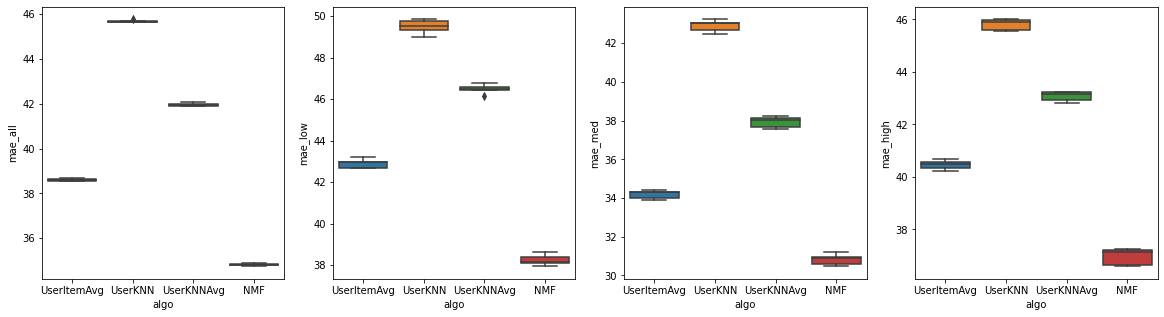

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
sns.boxplot(data=performance_data_cv_data, x="algo", y="mae_all", ax=axes[0])
sns.boxplot(data=performance_data_cv_data, x="algo", y="mae_low", ax=axes[1])
sns.boxplot(data=performance_data_cv_data, x="algo", y="mae_med", ax=axes[2])
sns.boxplot(data=performance_data_cv_data, x="algo", y="mae_high", ax=axes[3])

<AxesSubplot:xlabel='fold', ylabel='mae_high'>

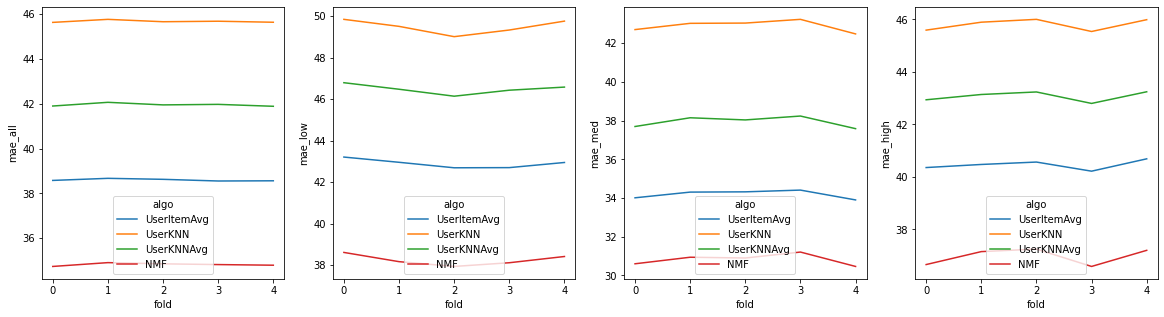

In [42]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
sns.lineplot(data=performance_data_cv_data, x="fold", y="mae_all", hue="algo", ax=axes[0])
sns.lineplot(data=performance_data_cv_data, x="fold", y="mae_low", hue="algo", ax=axes[1])
sns.lineplot(data=performance_data_cv_data, x="fold", y="mae_med", hue="algo", ax=axes[2])
sns.lineplot(data=performance_data_cv_data, x="fold", y="mae_high", hue="algo", ax=axes[3])


In [83]:
print(performance_data.drop(columns=["Unnamed: 0"]).to_latex(index=False))

\begin{tabular}{rrrrl}
\toprule
  mae\_all &   mae\_low &   mae\_med &  mae\_high &        algo \\
\midrule
38.561220 & 42.948022 & 33.900131 & 40.686397 & UserItemAvg \\
45.632008 & 49.759900 & 42.483605 & 45.991037 &     UserKNN \\
41.884150 & 46.580840 & 37.585348 & 43.242634 &  UserKNNAvg \\
34.879921 & 38.422262 & 30.596328 & 37.285075 &         NMF \\
\bottomrule
\end{tabular}



In [80]:
print(two_sample_ttest_data[(two_sample_ttest_data["dataset_x"] == "high") & (two_sample_ttest_data["dataset_y"] == "low")].drop(columns=["Unnamed: 0"])[["t_stat", "p_value", "algo_x"]].to_latex(index=False))


\begin{tabular}{rrl}
\toprule
    t\_stat &      p\_value &      algo\_x \\
\midrule
 -6.410088 & 1.457457e-10 & UserItemAvg \\
-10.222608 & 1.591726e-24 &     UserKNN \\
 -9.298158 & 1.442191e-20 &  UserKNNAvg \\
 -2.812836 & 4.911127e-03 &         NMF \\
\bottomrule
\end{tabular}



In [79]:
print(two_sample_ttest_data[(two_sample_ttest_data["dataset_x"] == "high") & (two_sample_ttest_data["dataset_y"] == "med")].drop(columns=["Unnamed: 0"])[["t_stat", "p_value", "algo_x"]].to_latex(index=False))


\begin{tabular}{rrl}
\toprule
   t\_stat &       p\_value &      algo\_x \\
\midrule
22.929584 & 3.103631e-116 & UserItemAvg \\
11.444310 &  2.554827e-30 &     UserKNN \\
18.746801 &  2.326156e-78 &  UserKNNAvg \\
19.749972 &  9.343993e-87 &         NMF \\
\bottomrule
\end{tabular}



In [78]:
print(two_sample_ttest_data[(two_sample_ttest_data["dataset_x"] == "med") & (two_sample_ttest_data["dataset_y"] == "low")].drop(columns=["Unnamed: 0"])[["t_stat", "p_value", "algo_x"]].to_latex(index=False))


\begin{tabular}{rrl}
\toprule
    t\_stat &       p\_value &      algo\_x \\
\midrule
-29.358120 & 4.041204e-189 & UserItemAvg \\
-22.710111 & 4.682693e-114 &     UserKNN \\
-28.603068 & 1.225187e-179 &  UserKNNAvg \\
-22.499055 & 5.522408e-112 &         NMF \\
\bottomrule
\end{tabular}



In [87]:
print(performance_data_cv_data.drop(columns=["Unnamed: 0", "fold"]).groupby("algo").mean().reset_index().to_latex(index=False))

\begin{tabular}{lrrrr}
\toprule
       algo &   mae\_all &   mae\_low &   mae\_med &  mae\_high \\
\midrule
        NMF & 34.826228 & 38.251262 & 30.819504 & 36.966665 \\
UserItemAvg & 38.597781 & 42.901547 & 34.188141 & 40.458539 \\
    UserKNN & 45.670528 & 49.491061 & 42.900413 & 45.805219 \\
 UserKNNAvg & 41.951480 & 46.484833 & 37.940609 & 43.071083 \\
\bottomrule
\end{tabular}



In [77]:
print(two_sample_ttest_data_cv[(two_sample_ttest_data_cv["dataset_x"] == "high") & (two_sample_ttest_data_cv["dataset_y"] == "low")].drop(columns=["Unnamed: 0"])[["t_stat", "p_value", "algo_x"]].to_latex(index=False))

\begin{tabular}{rrl}
\toprule
    t\_stat &       p\_value &      algo\_x \\
\midrule
-15.676295 &  2.229392e-55 & UserItemAvg \\
-22.666401 & 1.024629e-113 &     UserKNN \\
-21.540912 & 6.786349e-103 &  UserKNNAvg \\
 -7.193133 &  6.336360e-13 &         NMF \\
\bottomrule
\end{tabular}



In [76]:
print(two_sample_ttest_data_cv[(two_sample_ttest_data_cv["dataset_x"] == "high") & (two_sample_ttest_data_cv["dataset_y"] == "med")].drop(columns=["Unnamed: 0"])[["t_stat", "p_value", "algo_x"]].to_latex(index=False))

\begin{tabular}{rrl}
\toprule
   t\_stat &       p\_value &      algo\_x \\
\midrule
47.337713 &  0.000000e+00 & UserItemAvg \\
21.211420 & 7.801148e-100 &     UserKNN \\
38.031295 &  0.000000e+00 &  UserKNNAvg \\
40.644507 &  0.000000e+00 &         NMF \\
\bottomrule
\end{tabular}



In [75]:
print(two_sample_ttest_data_cv[(two_sample_ttest_data_cv["dataset_x"] == "med") & (two_sample_ttest_data_cv["dataset_y"] == "low")].drop(columns=["Unnamed: 0"])[["t_stat", "p_value", "algo_x"]].to_latex(index=False))

\begin{tabular}{rrl}
\toprule
    t\_stat &  p\_value &      algo\_x \\
\midrule
-63.123592 &      0.0 & UserItemAvg \\
-46.030867 &      0.0 &     UserKNN \\
-60.765132 &      0.0 &  UserKNNAvg \\
-47.696417 &      0.0 &         NMF \\
\bottomrule
\end{tabular}



In [74]:
print(paired_sample_ttest_data_cv[(paired_sample_ttest_data_cv["algo_x"] == "NMF")].drop(columns=["Unnamed: 0"])[["t_stat", "p_value", "algo_y", "dataset_x"]].to_latex(index=False))

\begin{tabular}{rrll}
\toprule
     t\_stat &  p\_value &      algo\_y & dataset\_x \\
\midrule
 -88.080805 &      0.0 & UserItemAvg &       low \\
 -92.817506 &      0.0 & UserItemAvg &       med \\
 -71.221515 &      0.0 & UserItemAvg &      high \\
-145.436214 &      0.0 & UserItemAvg &       all \\
-185.467541 &      0.0 &     UserKNN &       low \\
-256.779993 &      0.0 &     UserKNN &       med \\
-161.269761 &      0.0 &     UserKNN &      high \\
-351.666213 &      0.0 &     UserKNN &       all \\
-134.412910 &      0.0 &  UserKNNAvg &       low \\
-168.504432 &      0.0 &  UserKNNAvg &       med \\
-113.566081 &      0.0 &  UserKNNAvg &      high \\
-240.907508 &      0.0 &  UserKNNAvg &       all \\
\bottomrule
\end{tabular}

